## Reading and cleaning up the data

##### The data is from the [NOAA Climate Data Online tool](https://www.ncdc.noaa.gov/cdo-web/)

##### Documentation (including descriptions of each variable) can be found at [this link](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf) 

In [722]:
import datetime
import matplotlib.pyplot as plt # Import matplotlib for plotting and use magic command for Jupyter Notebooks
%matplotlib inline
import numpy as np
import pandas as pd # Pandas is used for data manipulation

In [723]:
# ---------------------- Set variable to predict ----------------------

var_predict = 'TMIN' # good choices are 'TAVG', 'TMIN', 'TMAX', others are available see df columns below

# ---------------------------------------------------------------------

In [724]:
# Read in data
conditions_df = pd.read_csv('weatherData_KSEA_2000-2024_full_year.csv')

# Display first 5 rows
conditions_df.head(5)

,STATION,DATE,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22,WV01,WV03
0,USW00024233,2000-01-01,12.30,450.0,457.0,0.27,NaN,NaN,40.0,43,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00024233,2000-01-02,8.95,611.0,339.0,0.00,NaN,NaN,25.0,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00024233,2000-01-03,9.40,2121.0,2120.0,0.28,NaN,NaN,42.0,47,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00024233,2000-01-04,13.42,928.0,933.0,0.30,NaN,NaN,46.0,50,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00024233,2000-01-05,6.71,1209.0,1646.0,0.00,NaN,NaN,41.0,44,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [725]:
# Check if TAVG is between TMIN and TMAX
# Select the rows where TAVG is not between TMIN and TMAX
invalid_rows = conditions_df[(conditions_df['TAVG'] < conditions_df['TMIN']) | (conditions_df['TAVG'] > conditions_df['TMAX'])]

# Count the number of invalid rows
invalid_count = len(invalid_rows)

# Print the count of invalid rows
print(f"Number of invalid rows where TAVG is not between TMIN and TMAX: {invalid_count}")

# Print the dates, TAVG, TMIN, and TMAX of the invalid rows
if invalid_count > 0:
    print("Dates of invalid rows with TAVG, TMIN, TMAX:")
    print(invalid_rows[['DATE', 'TAVG', 'TMIN', 'TMAX']])

    # Set TAVG, TMIN, TMAX to NaN for these invalid rows
    conditions_df.loc[(conditions_df['TAVG'] < conditions_df['TMIN']) | (conditions_df['TAVG'] > conditions_df['TMAX']), ['TAVG', 'TMIN', 'TMAX']] = np.nan
else:
    print("All rows are valid.")

Number of invalid rows where TAVG is not between TMIN and TMAX: 15
Dates of invalid rows with TAVG, TMIN, TMAX:
            DATE  TAVG  TMIN  TMAX
1     2000-01-02  25.0  37.0    45
459   2001-04-04  82.0  34.0    67
561   2001-07-15  65.0  52.0    59
1433  2003-12-04   0.0  39.0    51
1488  2004-01-28  41.0  44.0    49
5235  2014-05-02  66.0  51.0    65
5704  2015-08-14  67.0  59.0    65
5978  2016-05-14  61.0  53.0    58
7079  2019-05-20  58.0  52.0    57
7308  2020-01-04  47.0  40.0    46
7468  2020-06-12  60.0  53.0    59
8203  2022-06-17  58.0  53.0    57
8364  2022-11-25  47.0  37.0    46
8560  2023-06-09  58.0  52.0    56
9001  2024-08-23  60.0  55.0    59


In [726]:
# Drop the station column as they are all the same station: SeaTac
conditions_df.drop(columns=['STATION'], inplace=True, errors='ignore')

In [727]:
# Drop the columns with names 'SNOW', 'SNWD', 'TSUN' if they exist as they are unfortunately unreliable
# Note: these specific variables seems to be missing at different time periods, may want to look into if
#       they can be used for certain time subsets
conditions_df.drop(columns=['FMTM', 'PGTM', 'SNOW', 'SNWD', 'TSUN', 'WESD'], inplace=True, errors='ignore')

In [728]:
# Replace NaN in columns WT01 through WT22, WV01 and WV03 with 0
columns_to_fill = [f'WT{i:02d}' for i in range(1, 23)] + ['WV01', 'WV03']

# Fill NaN values with 0 for specified columns
conditions_df.fillna({col: 0 for col in columns_to_fill if col in conditions_df.columns}, inplace=True)

In [729]:
# Loop through all columns, excluding 'date' (since we don't need a 1d or 2d prior 'date' column)
for column in conditions_df.columns:
    if column != 'DATE':  # Skip the 'date' column
        # Create columns for variables from 1 and 2 days prior using shift
        conditions_df[f'{column}_1d_prior'] = conditions_df[column].shift(1)
        conditions_df[f'{column}_2d_prior'] = conditions_df[column].shift(2)

In [730]:
# Drop all original columns except for 'date' and var_predict
columns_to_drop = [col for col in conditions_df.columns if col not in ['DATE', var_predict] and '_prior' not in col]
conditions_df.drop(columns=columns_to_drop, inplace=True)

In [731]:
# Rename var_predict + '_ACTUAL'
var_predict_ACTUAL = var_predict + '_ACTUAL'
conditions_df.rename(columns={var_predict: var_predict_ACTUAL}, inplace=True)

In [732]:
# Drop the first two rows as they don't have prior data
conditions_df.drop(index=[0, 1], inplace=True)

In [733]:
# Remove rows where data is missing or wasn't physical (NaN values)
conditions_df.dropna(inplace=True)

In [734]:
# Shows first 5 rows
conditions_df.head(5)

,DATE,TMIN_ACTUAL,AWND_1d_prior,AWND_2d_prior,PRCP_1d_prior,PRCP_2d_prior,TAVG_1d_prior,TAVG_2d_prior,TMAX_1d_prior,TMAX_2d_prior,...,WT19_1d_prior,WT19_2d_prior,WT21_1d_prior,WT21_2d_prior,WT22_1d_prior,WT22_2d_prior,WV01_1d_prior,WV01_2d_prior,WV03_1d_prior,WV03_2d_prior
4,2000-01-05,37.0,13.42,9.40,0.30,0.28,46.0,42.0,50.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2000-01-06,33.0,6.71,13.42,0.00,0.30,41.0,46.0,44.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2000-01-07,40.0,5.59,6.71,0.03,0.00,37.0,41.0,41.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2000-01-08,36.0,8.95,5.59,0.21,0.03,43.0,37.0,46.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2000-01-09,35.0,14.32,8.95,0.32,0.21,41.0,43.0,46.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [735]:
print('The shape of our features is:', conditions_df.shape)

The shape of our features is: (6154, 62)


In [736]:
# Descriptive statistics for each column
conditions_df.describe()

,TMIN_ACTUAL,AWND_1d_prior,AWND_2d_prior,PRCP_1d_prior,PRCP_2d_prior,TAVG_1d_prior,TAVG_2d_prior,TMAX_1d_prior,TMAX_2d_prior,TMIN_1d_prior,...,WT19_1d_prior,WT19_2d_prior,WT21_1d_prior,WT21_2d_prior,WT22_1d_prior,WT22_2d_prior,WV01_1d_prior,WV01_2d_prior,WV03_1d_prior,WV03_2d_prior
count,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,...,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000
mean,46.292168,7.494797,7.499087,0.104319,0.104756,53.472051,53.460838,61.230094,61.213032,46.293305,...,0.000812,0.000812,0.012675,0.012675,0.002437,0.002437,0.001300,0.001300,0.000650,0.000650
std,8.974028,2.989368,2.991747,0.247841,0.248694,10.523419,10.506258,13.055111,13.037668,8.963871,...,0.028495,0.028495,0.111875,0.111875,0.049314,0.049314,0.036035,0.036035,0.025489,0.025489
min,15.000000,0.000000,0.000000,0.000000,0.000000,17.000000,17.000000,22.000000,22.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,5.370000,5.370000,0.000000,0.000000,45.000000,45.000000,51.000000,51.000000,39.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.000000,6.930000,6.930000,0.000000,0.000000,53.000000,53.000000,60.000000,60.000000,47.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,54.000000,9.170000,9.170000,0.090000,0.090000,62.000000,62.000000,71.000000,71.000000,54.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,73.000000,21.030000,21.030000,5.020000,5.020000,91.000000,91.000000,108.000000,108.000000,73.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visually checking the data

In [737]:
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in conditions_df['DATE']]

Text(0.5, 1.0, 'Presence of Hail')

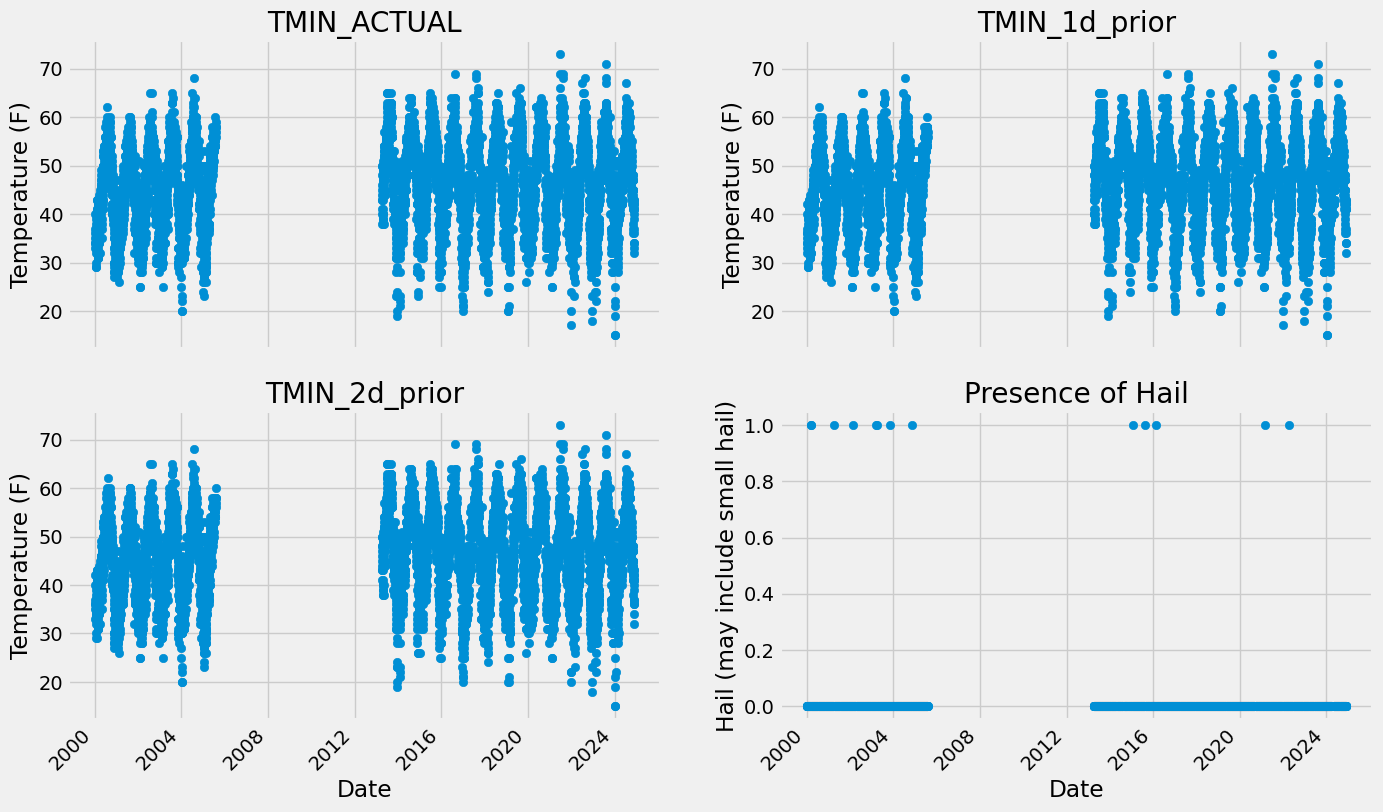

In [738]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Actual avg temperature measurement
ax1.scatter(dates, conditions_df[var_predict_ACTUAL])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title(var_predict_ACTUAL)

var_predict_1d_prior = var_predict + '_1d_prior'

# Temperature from 1 day ago
ax2.scatter(dates, conditions_df[var_predict_1d_prior])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature (F)'); ax2.set_title(var_predict_1d_prior)

var_predict_2d_prior = var_predict + '_2d_prior'

# Temperature from 2 days ago
ax3.scatter(dates, conditions_df[var_predict_2d_prior])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature (F)'); ax3.set_title(var_predict_2d_prior)

# Temperature from 2 days ago
ax4.scatter(dates, conditions_df['WT05_1d_prior'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Hail (may include small hail)'); ax4.set_title('Presence of Hail')

For some reason, the TAVG (Avg Temp) is missing from mid-2005 to early-2013. If any of TAVG, TMIN, TMAX are missing all are removed

# Further data preparation
### Seperating features and labels

In [739]:
# First remove date column as it is categorical and not used
conditions_df.drop(columns=['DATE'], inplace=True, errors='ignore')

# Use numpy to convert to arrays #
# Labels are the values we want to predict
labels = np.array(conditions_df[var_predict_ACTUAL])
# Remove the labels from the features
# axis 1 refers to the columns
conditions_df.drop(columns=[var_predict_ACTUAL], inplace=True, errors='ignore')
# Saving feature names for later use
feature_list = list(conditions_df.columns)
# Convert to numpy array
features = np.array(conditions_df)

### Splitting the data randomly into Test and Training sets
random_state = 42 ensure the similarity of the split in each iteration

In [740]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [741]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (4615, 60)
Training Labels Shape: (4615,)
Testing Features Shape: (1539, 60)
Testing Labels Shape: (1539,)


### Setting up the model baseline

In [742]:
# currently removed as we don't have a good baseline in the dataset
'''
# The baseline predictions are [TBD]
baseline_preds = test_features[:, feature_list.index('TBD')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))
''';

### Initializing a random forest regression model

In [743]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

### Assessing the performance of a model

In [744]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees', flush=True)

Mean Absolute Error: 2.33 degrees


In [745]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%', flush=True)

Accuracy: 94.54 %


In [746]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances_sorted = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
for pair in feature_importances_sorted:
    print('Variable: {:20} Importance: {}'.format(*pair), flush=True)

Variable: TMIN_1d_prior        Importance: 0.57
Variable: TAVG_1d_prior        Importance: 0.29
Variable: TMAX_1d_prior        Importance: 0.04
Variable: AWND_1d_prior        Importance: 0.01
Variable: AWND_2d_prior        Importance: 0.01
Variable: PRCP_1d_prior        Importance: 0.01
Variable: TAVG_2d_prior        Importance: 0.01
Variable: TMAX_2d_prior        Importance: 0.01
Variable: TMIN_2d_prior        Importance: 0.01
Variable: WDF2_1d_prior        Importance: 0.01
Variable: WDF2_2d_prior        Importance: 0.01
Variable: WDF5_1d_prior        Importance: 0.01
Variable: WDF5_2d_prior        Importance: 0.01
Variable: WSF2_1d_prior        Importance: 0.01
Variable: WSF5_1d_prior        Importance: 0.01
Variable: WSF5_2d_prior        Importance: 0.01
Variable: PRCP_2d_prior        Importance: 0.0
Variable: WSF2_2d_prior        Importance: 0.0
Variable: WT01_1d_prior        Importance: 0.0
Variable: WT01_2d_prior        Importance: 0.0
Variable: WT02_1d_prior        Importance: 0

In [747]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Get the two most important feature names
feature_name_1 = feature_importances_sorted[0][0]
feature_name_2 = feature_importances_sorted[1][0]
feature_importances[0][0]
# Extract the two most important features
important_indices = [feature_list.index(feature_name_1), feature_list.index(feature_name_2)]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%', flush=True)

Mean Absolute Error: 2.65 degrees.
Accuracy: 93.8 %


Text(0.5, 1.0, 'Variable Importances')

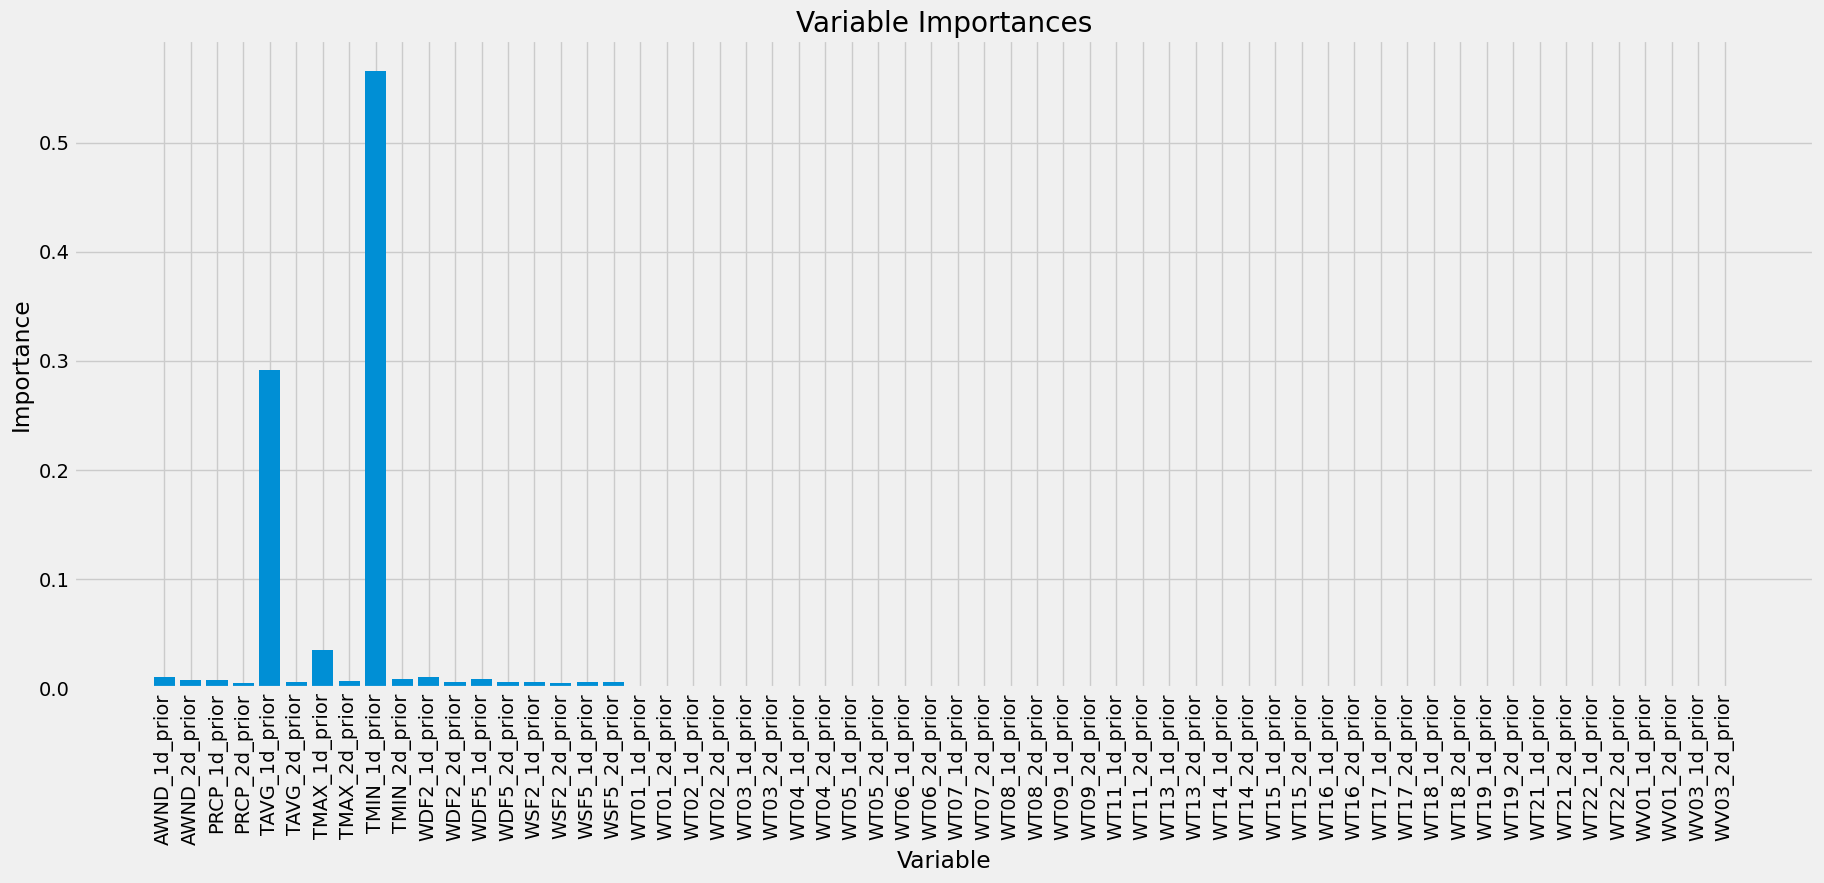

In [748]:
fig, ax = plt.subplots(1,1, figsize=(20,8))

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')